In [1]:
import seaborn as sns; sns.set(font="IPAexGothic")
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
print(sns.__version__)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

np.random.seed(1000)

d = pd.read_csv("Y_TEST.csv")

0.9.0


# stanコード

In [2]:
import pystan
#;のあとにスペース TABがあるとエラー吐く
model = '''
data {
    int N;
    int Y[N];
}
parameters {
    vector[N] r;
    real<lower=0> s;
    real<lower=0> beta;
}
model {
  for (j in 3: N )
      r[j] ~ normal( 2*r[j-1]-r[j-2] , s);
  Y ~ poisson_log( r + beta );
}
generated quantities{
    vector[N] Y_mean;
    Y_mean =exp( r+beta );
}
'''

In [3]:
dat = {'N': d.shape[0],
       'Y': d[d.columns[0]]
      }
n_itr = 10000
n_warmup = 3000
#モデル作成
%time model = pystan.StanModel(model_code=model)
#サンプリング実行
%time fit = model.sampling(data=dat, iter=n_itr, warmup=n_warmup)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_411ced01b80a6733af775d84a2eabf85 NOW.


Wall time: 54.8 s


Wall time: 1min 4s


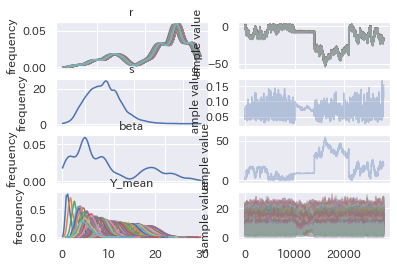

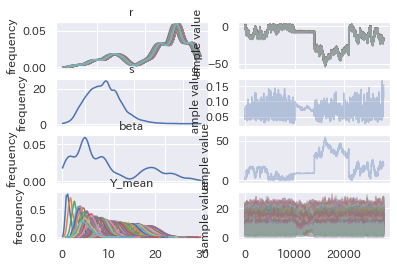

In [4]:
fit.plot()

In [11]:
print(fit.stansummary(pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2))

Inference for Stan model: anon_model_411ced01b80a6733af775d84a2eabf85.
4 chains, each with iter=10000; warmup=3000; thin=1; 
post-warmup draws per chain=7000, total post-warmup draws=28000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r[1]         -16.5    8.65  13.28 -45.09 -26.49 -11.97  -7.39  -0.54      2   2.91
r[2]        -16.13    8.65  13.28  -44.7 -26.02 -11.59  -7.01   -0.2      2   2.92
r[3]        -15.76    8.65  13.28 -44.31 -25.68 -11.22  -6.63   0.15      2   2.92
r[4]         -15.4    8.65  13.27 -43.95  -25.4 -10.85  -6.28    0.5      2   2.92
r[5]        -15.08    8.65  13.27 -43.64 -25.14 -10.54  -5.96   0.84      2   2.92
r[6]        -14.79    8.65  13.27 -43.35  -24.9 -10.25  -5.67   1.12      2   2.92
r[7]        -14.54    8.65  13.27 -43.11 -24.67  -10.0  -5.42   1.38      2   2.92
r[8]        -14.33    8.65  13.27 -42.92  -24.5   -9.8  -5.22   1.59      2   2.92
r[9]        -14.17    8.65  13.27 -42.76 -24.35  -9.64  -5.06 

In [6]:
r_d = pd.DataFrame(fit['r'])
r_d.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-6.515385,-6.155249,-5.825721,-5.564188,-5.276796,-5.034434,-4.786432,-4.572336,-4.359106,-4.176057,...,-4.629560,-4.697053,-4.810657,-4.874039,-4.936069,-4.984833,-5.055185,-5.129749,-5.177998,-5.277729
1,-0.781954,-0.628197,-0.467787,-0.285619,-0.089695,0.045868,0.253268,0.537524,0.741909,0.841116,...,0.404760,0.422100,0.373461,0.347523,0.350136,0.358280,0.301605,0.207483,0.038985,-0.175885
2,-15.547194,-15.230861,-14.900072,-14.590837,-14.369667,-14.242124,-14.015380,-13.757498,-13.529525,-13.392730,...,-13.925316,-13.841051,-13.786649,-13.785304,-13.770754,-13.887276,-14.023289,-14.170776,-14.329137,-14.492168
3,0.090567,0.397450,0.740356,1.026421,1.283652,1.520345,1.783747,2.039307,2.246354,2.435961,...,1.629950,1.549319,1.570886,1.510911,1.428821,1.346487,1.172852,1.016163,0.859932,0.703768
4,-8.340677,-7.982321,-7.634701,-7.343201,-7.054538,-6.639411,-6.263945,-5.967901,-5.673433,-5.538672,...,-5.945738,-5.987883,-6.019861,-6.022309,-6.103482,-6.173897,-6.284466,-6.475848,-6.717091,-7.115465


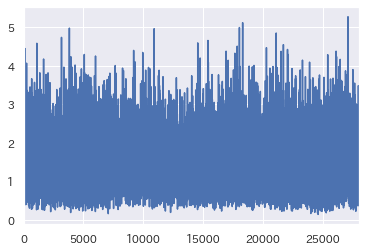

In [13]:
result = pd.DataFrame(fit.extract()['Y_mean'])
result[0].plot()

Text(0, 0.5, 'number of individuals $y_j$')

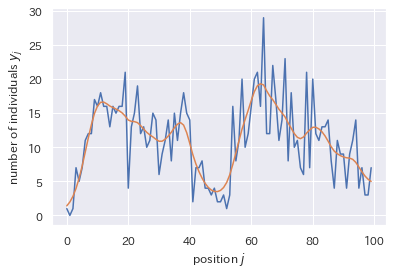

In [17]:
sns.lineplot(y=d[d.columns[0]],x=d.index)
sns.lineplot(y=Y_mean.mean(),x=range(len(Y_mean.mean())))
plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')

In [15]:
q_range = [0.1,0.25,0.75,0.9]
Y_mean_quntile = Y_mean.quantile(q_range).T
Y_mean_quntile

,0.10,0.25,0.75,0.90
0,0.747695,0.980279,1.728226,2.180331
1,1.221675,1.528982,2.342194,2.819529
2,1.951179,2.321458,3.220885,3.725299
3,2.978402,3.412948,4.449878,4.979537
4,4.293413,4.802829,6.020860,6.619547
...,...,...,...,...
95,5.754710,6.337854,7.803164,8.529590
96,5.114676,5.681400,7.072674,7.745193
97,4.454091,5.019511,6.483250,7.146191
98,3.839259,4.439229,6.101138,6.970116


Text(0, 0.5, 'number of individuals $y_j$')

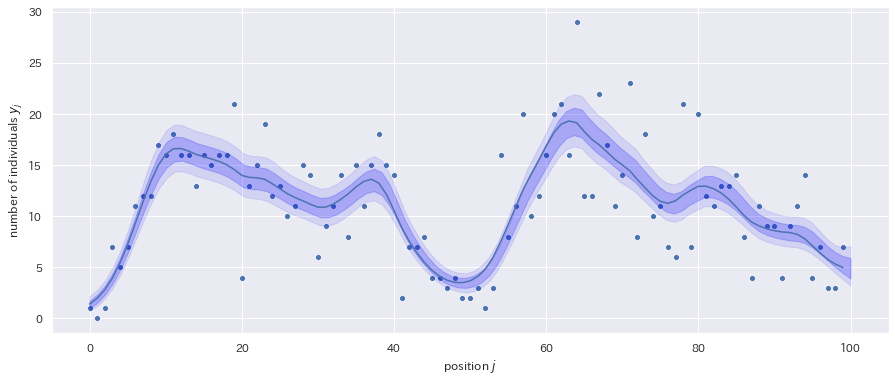

In [16]:
# 描画
plt.figure(figsize=(15,6))

x = np.linspace(0, len(Y_mean_quntile), len(Y_mean_quntile))
q010 = Y_mean_quntile[Y_mean_quntile.columns[0]] #0.1
q025 = Y_mean_quntile[Y_mean_quntile.columns[1]] #0.25
q075 = Y_mean_quntile[Y_mean_quntile.columns[2]] #0.75
q090 = Y_mean_quntile[Y_mean_quntile.columns[3]] #0.9

sns.scatterplot(y=d[d.columns[0]],x=d.index)
sns.lineplot(y=Y_mean.mean(),x=range(len(Y_mean.mean())))
plt.fill_between(x, q025, q075, color='blue', alpha=0.2)
plt.fill_between(x, q010, q090, color='blue', alpha=0.1)

plt.xlabel('position $j$')
plt.ylabel('number of individuals $y_j$')